In [31]:
import numpy as np
import os 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.stats

In [2]:


if 'src' in os.getcwd():
    os.chdir('..')
    
from statrob import StatrobGlobal, MLPClassifier
from create_data_examples import Dataset, DatasetPreprocessor
from explainers import GrowingSpheresExplainer
from plot_helpers import plot_crisp_decision_boundary, plot_decision_boundary_with_artifacts
from experiments_helpers import SameSampleExperimentData
from statrob import plot_beta_on_original, estimate_beta_distribution, ensemble_predict_proba, plot_beta, plot_distribution_of_predictions


dataset = Dataset('moons')
# dataset_preprocessor = DatasetPreprocessor(dataset, one_hot=True)


e1 = SameSampleExperimentData(
        dataset, 
        random_state=324,
        one_hot_encode=True,
        standardize='minmax'
    )

sample1, sample2 = e1.create()
X_train, X_test, y_train, y_test = sample1
X_train2, X_test2, y_train2, y_test2 = sample2

dataset_preprocessor = e1.preprocessor


blackbox = MLPClassifier(X_test.shape[1], seed=122, hidden_dims=[128, 128, 128])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
blackbox.fit(X_train, y_train, X_val, y_val)
acc, rec, prc, f1 = blackbox.evaluate(X_test, y_test)
print(f'Accuracy: {acc}, Recall: {rec}, Precision: {prc}, F1: {f1}')

blackbox2 = MLPClassifier(X_train2.shape[1], seed=123)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)
blackbox2.fit(X_train2, y_train2, X_val2, y_val2)
acc2, rec2, prc2, f12 = blackbox2.evaluate(X_test, y_test)
print(f'Accuracy: {acc2}, Recall: {rec2}, Precision: {prc2}, F1: {f12}')

2024-03-05 01:36:34.412689: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 01:36:34.441332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/ignacy/research/robust-cf
Epoch: 0, Loss: 0.6479032039642334
Epoch: 0, Validation Loss: 0.6539438962936401
Epoch: 5, Validation Loss: 0.36616775393486023
Epoch: 10, Loss: 0.2731361985206604
Epoch: 10, Validation Loss: 0.3385801911354065
Epoch: 15, Validation Loss: 0.31713753938674927
Epoch: 20, Loss: 0.23646612465381622
Epoch: 20, Validation Loss: 0.28822073340415955
Epoch: 25, Validation Loss: 0.2549770474433899
Epoch: 30, Loss: 0.18906636536121368
Epoch: 30, Validation Loss: 0.22924396395683289
Epoch: 35, Validation Loss: 0.1854715645313263
Epoch: 40, Loss: 0.1698501855134964
Epoch: 40, Validation Loss: 0.1713952273130417
Epoch: 45, Validation Loss: 0.16071370244026184
Epoch: 50, Loss: 0.15605463087558746
Epoch: 50, Validation Loss: 0.14181557297706604
Epoch: 55, Validation Loss: 0.1301654428243637
Epoch: 60, Loss: 0.14770253002643585
Epoch: 60, Validation Loss: 0.12354928255081177
Epoch: 65, Validation Loss: 0.1200997605919838
Epoch: 70, Loss: 0.13465964794158936
Epoch: 70, Va

In [3]:
X_train_np = X_train.to_numpy()
y_train_np = y_train
X_test_np = X_test.to_numpy()
y_test_np = y_test


blackbox_predic_crisp_fn = lambda x: blackbox.predict_crisp(x).detach().numpy()
blackbox_predic_proba_fn = lambda x: blackbox.predict_proba(x).detach().numpy()
blackbox2_predic_crisp_fn = lambda x: blackbox2.predict_crisp(x).detach().numpy()
blackbox2_predic_proba_fn = lambda x: blackbox2.predict_proba(x).detach().numpy()

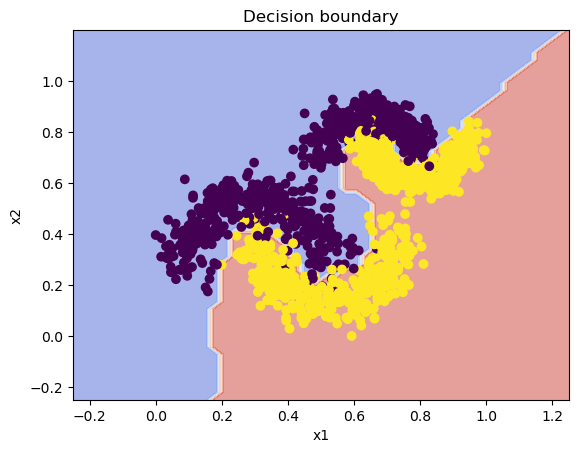

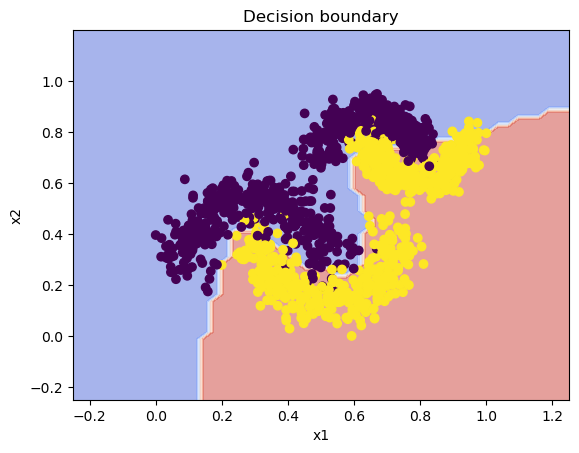

In [4]:

plot_crisp_decision_boundary(blackbox_predic_crisp_fn, X_train_np, y_train_np)
plot_crisp_decision_boundary(blackbox2_predic_crisp_fn, X_train_np, y_train_np)

In [5]:
gs_explainer = GrowingSpheresExplainer(
                    keys_mutable=dataset_preprocessor.X_train.columns.tolist(),
                    keys_immutable=[],
                    feature_order=dataset_preprocessor.X_train.columns.tolist(),
                    binary_cols=dataset_preprocessor.encoder.get_feature_names_out().tolist(),
                    continous_cols=dataset_preprocessor.continuous_columns,
                    pred_fn_crisp=blackbox_predic_crisp_fn,
                    target_proba=0.5,
                )    
gs_explainer.prep()

In [6]:
statrob_explainer = StatrobGlobal(
    dataset=dataset,
    preprocessor=dataset_preprocessor,
    blackbox=blackbox
)

statrob_explainer.fit(k_mlps=24, _bootstrap=False)

Training the ensemble of models
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping due to validation loss not improving.
Early stopping

In [7]:
from robx import robx_algorithm



<div style="background-color: #880000; color: #FFFFFF; font-weight: bold; padding: 10px; margin: 10px 0 20px 0; text-align: center; border-radius: 10px;">Generation</div>

In [42]:
idx = 16
original_example = X_test[idx:idx+1]
original_example_np = original_example.to_numpy().reshape(-1)
original_class = blackbox_predic_crisp_fn(original_example)
cf = gs_explainer.generate(original_example)
cf_class = blackbox_predic_crisp_fn(cf)


print(f'Original example class: {original_class}. Example: {original_example_np}')
print(f'Counterfactual class: {cf_class}. Counterfactual: {cf}')

Original example class: [1]. Example: [0.24053572 0.41193908]
Counterfactual class: [0]. Counterfactual: [0.2402214  0.41363314]


In [55]:
confidences = [0.6, 0.7, 0.8, 0.9, 0.95]
statrob_cfs = []
statrob_cfs_classes = []

for conf in confidences:
    statrob_cf = statrob_explainer.optimize(
        cf.reshape(1, -1), 
        target_class=cf_class, 
        estimation_method='MLE',
        desired_confidence=conf,
        classification_threshold=.5
    )
    statrob_cfs.append(statrob_cf)
    statrob_cf_class = blackbox_predic_crisp_fn(statrob_cf)
    statrob_cfs_classes.append(statrob_cf_class)
    print(f'Statrob Counterfactual class: {statrob_cf_class}. Counterfactual: {statrob_cf}')
    

Counterfactual does not have the target class!: 
Counterfactual [0.2401052 0.4135531] 
Prediction: 1, should be class: [0]. Proba: tensor([0.5013], grad_fn=<ViewBackward0>)
Statrob Counterfactual class: [1]. Counterfactual: [0.2401052 0.4135531]
Counterfactual does not have the target class!: 
Counterfactual [0.24006812 0.41332076] 
Prediction: 1, should be class: [0]. Proba: tensor([0.5054], grad_fn=<ViewBackward0>)
Statrob Counterfactual class: [1]. Counterfactual: [0.24006812 0.41332076]
Counterfactual does not have the target class!: 
Counterfactual [0.24127751 0.41202214] 
Prediction: 1, should be class: [0]. Proba: tensor([0.5306], grad_fn=<ViewBackward0>)
Statrob Counterfactual class: [1]. Counterfactual: [0.24127751 0.41202214]
Counterfactual does not have the target class!: 
Counterfactual [0.24032683 0.41358277] 
Prediction: 1, should be class: [0]. Proba: tensor([0.5010], grad_fn=<ViewBackward0>)
Statrob Counterfactual class: [1]. Counterfactual: [0.24032683 0.41358277]
Coun

In [50]:
robx_cf, _ = robx_algorithm(
    X_train = X_train.to_numpy(),
    predict_class_proba_fn = blackbox_predic_proba_fn,
    start_counterfactual = cf,
)

robx_cf_class = blackbox_predic_crisp_fn(robx_cf)
print(f'Robust Counterfactual class: {robx_cf_class}. Counterfactual: {robx_cf}')


Robust Counterfactual class: [0]. Counterfactual: [0.15085547 0.44134656]


In [36]:
def plot_decision_boundary_with_artifacts(
    predict_crisp_fn: callable,
    X: np.ndarray,
    y: np.ndarray,
    artifacts: list[dict],
    save_path: str = None,
    show: bool = True,
    ) -> None:
    '''
    Plot the decision boundary of a model along with the artifacts.
    
    Parameters:
        - model: the model (object)
        - X: the data (np.ndarray)
        - y: the labels (np.ndarray)
        - artifacts: list of artifacts (list[dict]) - [{'coords': np.ndarray, 'color': str, 'label': str, 'marker': str}]
        - save_path: the path to save the plot (str)
        - show: whether to show the plot or not (bool)
    '''

    # Prepare the grid
    xx = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
    yy = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 100)
    xx, yy = np.meshgrid(xx, yy)
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    

    fig, ax  = plt.subplots(figsize=(5,5))
    
    # Plot the crisp decision boundary
    preds = predict_crisp_fn(grid).reshape(xx.shape)
    
    ax.contourf(xx, yy, preds, 25, cmap="copper", vmin=0, vmax=1, alpha=0.3)
    ax.set_title("Counterfactual explanations vs decision boundary and data support")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    
    # Scatterplot the data distribution
    ax.scatter(X[y==0, 0], X[y==0, 1], c='gray', label='0', marker='o', alpha=0.3)
    ax.scatter(X[y==1, 0], X[y==1, 1], c='orange', label='1', marker='o', alpha=0.2)
    
    
    
    # Plot the artifacts
    # [{'coords': np.ndarray, 'color': str, 'label': str, 'marker': str}]
    for artifact in artifacts:
        ax.scatter(artifact['coords'][0], artifact['coords'][1], c=artifact['color'], label=artifact['label'], marker=artifact['marker'])
    
    # Move the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
        
    if show:
        plt.show()

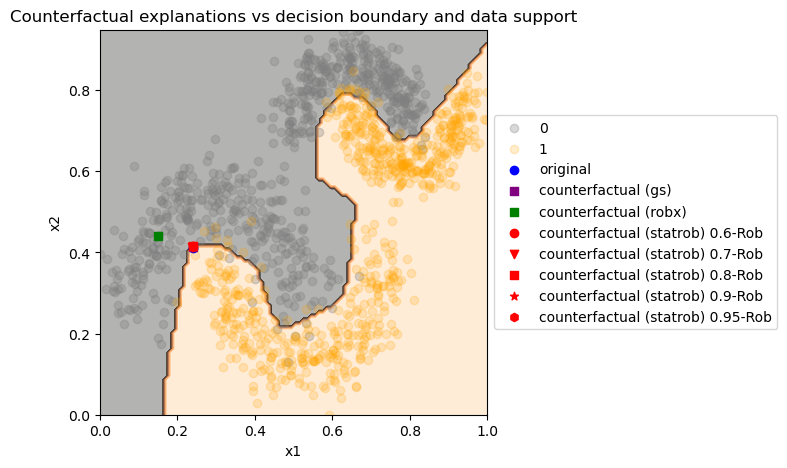

In [51]:
artifacts = [
    {'coords': original_example_np.reshape(-1), 'color': 'blue', 'marker': 'o', 'label': 'original'},
    {'coords': cf.reshape(-1), 'color': 'purple', 'marker': 's', 'label': 'counterfactual (gs)'},
    # {'coords': statrob_cf.reshape(-1), 'color': 'red', 'marker': 'o', 'label': 'counterfactual (statrob)'},
    {'coords': robx_cf.reshape(-1), 'color': 'green', 'marker': 's', 'label': 'counterfactual (robx)'},
]

avail_markers = ['o', 'v', 's', '*', 'h', 'H', 'D', 'd', 'P', 'X']
for i, (conf, _cf, _cf_class) in enumerate(zip(confidences, statrob_cfs, statrob_cfs_classes)):
    artifacts.append(
        {'coords': _cf.reshape(-1), 'color': 'red', 'marker': avail_markers[i], 'label': f'counterfactual (statrob) {conf}-Rob'}
    )

plot_decision_boundary_with_artifacts(
    blackbox_predic_crisp_fn, 
    X_train_np, 
    y_train_np,
    artifacts=artifacts
)

tensor([0], dtype=torch.int32)
Blackbox prediction: [1], target class: [0]


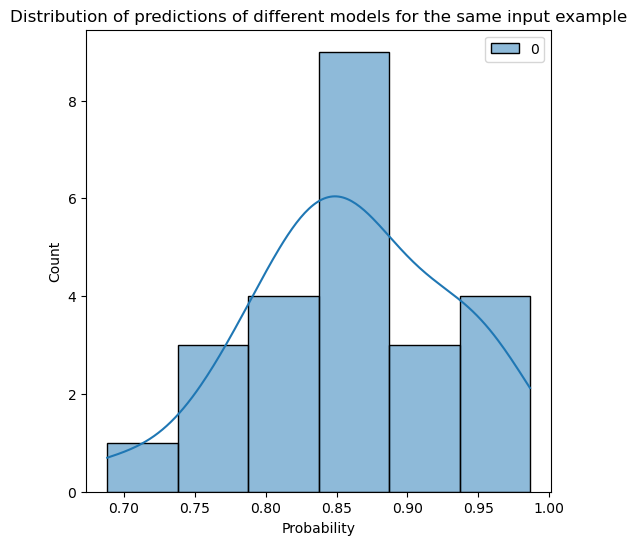

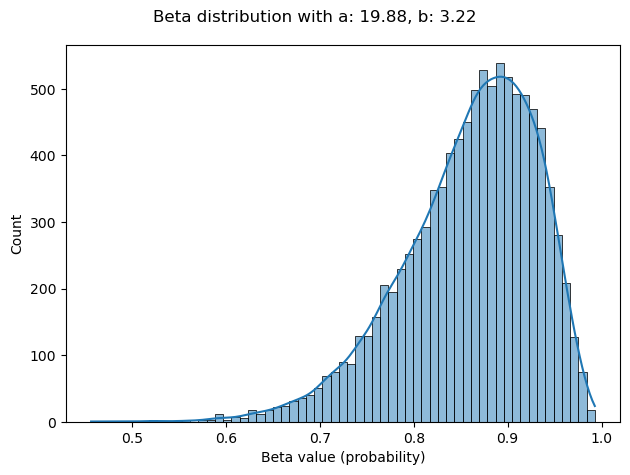

True

In [52]:
import torch
from statrob import ensemble_predict_proba

ccccc = statrob_cfs[0]
target_class = cf_class

blackbox_preds = blackbox.predict_crisp(ccccc)
print(blackbox_preds)
if isinstance(blackbox_preds, torch.Tensor):
    blackbox_preds = blackbox_preds.detach().numpy()
blackbox_preds = blackbox_preds if target_class == 1 else 1 - blackbox_preds
print(f'Blackbox prediction: {blackbox_preds}, target class: {target_class}')

preds = ensemble_predict_proba(statrob_explainer.models, ccccc)
preds = preds if target_class == 1 else 1 - preds

plot_distribution_of_predictions(preds)
alpha, beta, _, _ = scipy.stats.beta.fit(preds,  method='MM', floc=0, fscale=1)
plot_beta(alpha, beta)
        
statrob_explainer.test_beta_credible_interval(
                preds.flatten(),
                confidence=0.6, 
                thresh=0.5,
                estimation_method='MLE'
)

[[0.06769422441720963], [0.21928299963474274], [0.08987754583358765], [0.1308514028787613], [0.15475547313690186], [0.11866961419582367], [0.06365195661783218], [0.31176304817199707], [0.03804347664117813], [0.013469758443534374], [0.1931830197572708], [0.18010061979293823], [0.1458742916584015], [0.18703453242778778], [0.15643198788166046], [0.15080897510051727], [0.05222253501415253], [0.11562519520521164], [0.04811541736125946], [0.17023146152496338], [0.2435692846775055], [0.2226068526506424], [0.11792822182178497], [0.15665987133979797]]
[[0.9323057532310486], [0.7807170152664185], [0.9101224541664124], [0.8691486120223999], [0.8452445268630981], [0.8813303709030151], [0.936348021030426], [0.6882369518280029], [0.9619565010070801], [0.9865302443504333], [0.8068169951438904], [0.8198993802070618], [0.8541257381439209], [0.812965452671051], [0.8435680270195007], [0.8491910099983215], [0.9477774500846863], [0.8843747973442078], [0.9518845677375793], [0.8297685384750366], [0.756430745

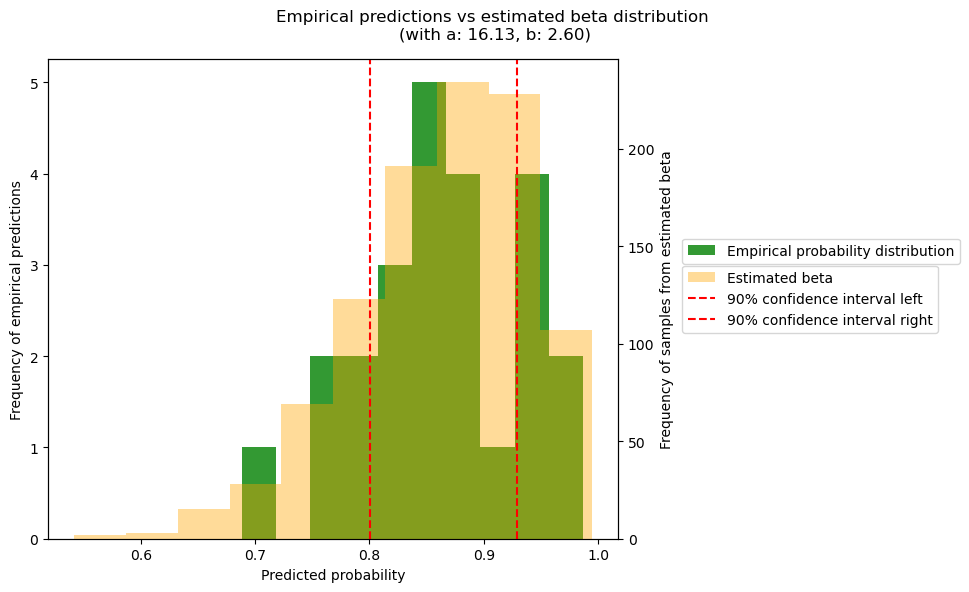

In [53]:


idx = 0
cccc =  statrob_cfs[idx]
class_ = int(statrob_cfs_classes[idx][0])
condifence = 0.6


probs = ensemble_predict_proba(statrob_explainer.models, cccc)
print(probs.tolist())
probs = probs if class_ == 1 else 1 - probs
print(probs.tolist())
alpha, beta, _, _ = scipy.stats.beta.fit(probs,  method='MLE', floc=0, fscale=1)
# plot_distribution_of_predictions(probs)
# plot_beta(alpha, beta)


left, right = scipy.stats.beta.interval(condifence, alpha, beta)


fig, ax = plt.subplots(figsize=(10,6))
samples = np.random.beta(alpha, beta, size=1000)

ax.hist(probs, bins=10, density=False, alpha=0.8, color='green', label='Empirical probability distribution')
ax2 = ax.twinx()
ax2.hist(samples, bins=10, density=False, alpha=0.4, color='orange', label='Estimated beta')

# Draw the 90% confidence interval
plt.axvline(left, color='red', linestyle='--', label='90% confidence interval left')
plt.axvline(right, color='red', linestyle='--', label='90% confidence interval right')

# Place legend outside the main plot box
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.6))


plt.suptitle(f'Empirical predictions vs estimated beta distribution \n(with a: {alpha:.2f}, b: {beta:.2f})')

ax.set_xlabel('Predicted probability')
ax.set_ylabel('Frequency of empirical predictions')
ax2.set_ylabel('Frequency of samples from estimated beta')


plt.tight_layout()

plt.show()